In [1]:
import numpy as np
import tensorflow as tf
from scapy.all import rdpcap
from sklearn.model_selection import train_test_split

In [5]:
from scapy.all import rdpcap, IP, Ether, CookedLinux
from scapy.layers.dot11 import Dot11
import os 
import numpy as np

ZERO_MAC = "00:00:00:00:00:00"

def _zero_mac(val=ZERO_MAC):
    return val

def _anonymize_wifi_addrs(pkt):
    if Dot11 not in pkt:
        return
    d11 = pkt[Dot11]
    # Zero any 802.11 address fields that exist on this frame
    for f in ("addr1", "addr2", "addr3", "addr4"):
        if hasattr(d11, f) and getattr(d11, f):
            setattr(d11, f, _zero_mac())

def remove_ip(packet):
    # Wi-Fi (802.11): zero all MAC-like addresses (RA/TA/SA/DA/BSSID)
    _anonymize_wifi_addrs(packet)

    # Ethernet / Linux SLL
    if Ether in packet:
        packet[Ether].src = _zero_mac()
        packet[Ether].dst = _zero_mac()
        # scapy will recalc L2/L3 checksums on serialization if deleted at L3/L4
    elif CookedLinux in packet:
        # Some scapy versions expose 'addr' instead of 'src'; be defensive
        if hasattr(packet[CookedLinux], "src"):
            packet[CookedLinux].src = _zero_mac()
        if hasattr(packet[CookedLinux], "addr"):
            packet[CookedLinux].addr = bytes.fromhex(ZERO_MAC.replace(":", ""))

    # L3 / L4
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'
        if hasattr(packet[IP], "chksum"):
            del packet[IP].chksum
        if packet.haslayer("TCP") and hasattr(packet["TCP"], "chksum"):
            del packet["TCP"].chksum
        elif packet.haslayer("UDP") and hasattr(packet["UDP"], "chksum"):
            del packet["UDP"].chksum
    return packet

def packet_to_bytes(pkt, max_len):
    pkt = remove_ip(pkt)
    raw = bytes(pkt)
    return raw[:max_len] if len(raw) > max_len else raw.ljust(max_len, b'\x00')

def extract_raw_bytes_from_folder(folder_path, max_len=100):
    all_features = []
    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            features = [packet_to_bytes(pkt, max_len) for pkt in packets]
            all_features.extend(features)
    return np.array([np.frombuffer(x, dtype=np.uint8) for x in all_features])


In [6]:
from scapy.all import rdpcap, wrpcap

def extract_raw_bytes_and_save_from_folder(folder_path, max_len=100, save_pcap_path=None):
    all_features = []
    all_packets = []

    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            for pkt in packets:
                pkt = remove_ip(pkt)
                all_packets.append(pkt)
                raw = bytes(pkt)
                raw_padded = raw.ljust(max_len, b'\x00')[:max_len]
                all_features.append(np.frombuffer(raw_padded, dtype=np.uint8))

    if save_pcap_path:
        wrpcap(save_pcap_path, all_packets)

    return np.array(all_features), all_packets  # X_attack, packets_attack


attack_folder = r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\attack-merged"
X_attack, packets_attack = extract_raw_bytes_and_save_from_folder(attack_folder, save_pcap_path=r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\anonymized_attack.pcap")

Processing C:\Users\ulami\Desktop\datasety\AWID3_pcap\attack-merged\attack_new.pcap


In [11]:
X_attack.shape

(332376, 100)

In [ ]:
normal_folder = r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\normal"

# Extract and label
X_normal = extract_raw_bytes_from_folder(normal_folder)
# X_attack = extract_raw_bytes_from_folder(attack_folder)

y_normal = np.zeros(X_normal.shape[0])
y_attack = np.ones(X_attack.shape[0])

# Combine data and labels
X = np.vstack((X_normal, X_attack))
y = np.hstack((y_normal, y_attack))

Processing C:\Users\ulami\Desktop\datasety\AWID3_pcap\normal\reAssoc_normal_frames.pcap


In [12]:
X_normal.shape

(1838436, 100)

In [13]:
X.shape

(2170812, 100)

In [14]:
# Combine for full dataset
X_all = np.vstack((X_normal, X_attack))
y_all = np.hstack((y_normal, y_attack))

# Normalize data before splitting
X_all = X_all.astype(np.float32) / 255.0

attack_start_idx = len(X_normal)
all_indices = np.arange(len(X_all))

# Split dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all, y_all, all_indices, test_size=0.2, random_state=42, stratify=y_all
)

# CNN reshape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [17]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\AWID_csv_final2.keras")   

In [18]:
final_model.summary()

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_977 (Dense)               │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_980 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,077 (199.52 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,052 (133.02 KB)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(input_dim: int):
    """
    Builds a 1D CNN.
    """
    m = Sequential()
    n_channels = 1
    m.add(Input(shape=(input_dim, n_channels)))

    for i in range(best_params['n_layers']):
        filters = best_params.get(f"n_units_l{i}")            # use your existing units as conv filters
        ksize   = 5
        dr      = best_params.get(f"dropout_l{i}", 0.0)
        poolsz  = best_params.get(f"pool_size_l{i}")          # set >1 to enable per-layer pooling

        m.add(Conv1D(filters=filters, kernel_size=ksize,
                     activation='relu', padding='same'))
        if poolsz and poolsz > 1:
            m.add(MaxPooling1D(pool_size=poolsz))
        if dr and dr > 0:
            m.add(Dropout(dr))

    m.add(GlobalMaxPooling1D())
    # m.add(Dense(32, activation='relu'))
    m.add(Dense(1, activation='sigmoid'))

    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m


In [18]:
best_params = {
    'epochs': 3,
    'n_layers': 3,
    'n_units_l0': 32, 'dropout_l0': 0.0,
    # 'n_units_l1': 64, 'dropout_l1': 0.0,
    'n_units_l1': 32, 'dropout_l1': 0.0,
    'n_units_l2': 16, 'dropout_l2': 0.0,
    # 'n_units_l4': 64, 'dropout_l4': 0.0,
    'learning_rate': 1e-3,
    'batch_size': 32
}

In [21]:
model = build_model(input_dim=X_train.shape[1])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model = build_model(input_dim=X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1
)

test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

Epoch 1/3
43417/43417 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - accuracy: 0.9803 - loss: 0.0565 - val_accuracy: 0.9975 - val_loss: 0.0082
Epoch 2/3
43417/43417 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - accuracy: 0.9981 - loss: 0.0062 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 3/3
43417/43417 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9985 - val_loss: 0.0040
13568/13568 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

13568/13568 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.99


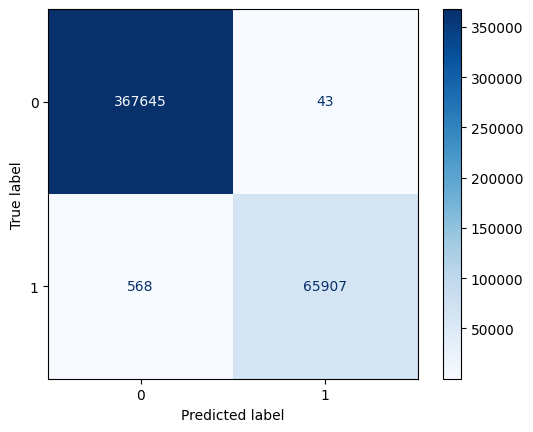

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    367688
        Attack       1.00      0.99      1.00     66475

      accuracy                           1.00    434163
     macro avg       1.00      1.00      1.00    434163
  weighted avg       1.00      1.00      1.00    434163



In [21]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))

In [22]:
# Save the trained model
model.save("awid_pcap_final.keras")

In [1]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\awid_pcap_final.keras")   

# Integrated gradient

In [23]:
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape) # średnia / średnia normalnych / mediana normalnych ?? 

    interpolated_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]

    grads = []
    for inp in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
        grad = tape.gradient(pred, inp)
        grads.append(grad.numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (input_tensor.numpy() - baseline.numpy()) * avg_grads
    return integrated_grads.squeeze()

def compute_ig_for_samples(model, X_subset, steps=50, max_samples=100, baseline=None):
    attributions_list = []
    for i in range(min(len(X_subset), max_samples)):
        input_sample = tf.convert_to_tensor([X_subset[i]], dtype=tf.float32)
        ig = compute_integrated_gradients(model, input_sample, baseline=baseline, steps=steps)
        attributions_list.append(ig)
    return np.array(attributions_list)

# Separate test samples
X_normal_test = X_test[y_test == 0]
X_attack_test = X_test[y_test == 1]


In [24]:
a_normal_min = X_normal_test.shape[0] *0.01
a_normal_max = X_normal_test.shape[0] *0.05

a_attack_min = X_attack_test.shape[0] *0.01
a_attack_max = X_attack_test.shape[0] *0.05

a_normal_min, a_normal_max, a_attack_min, a_attack_max

(3676.88, 18384.4, 664.75, 3323.75)

In [25]:
import pandas as pd

# Compute IG
normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=3000)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000)
# overall_attributions = compute_ig_for_samples(model, X_test, max_samples=500)

# Average IG
avg_normal_ig = np.mean(normal_attributions, axis=0)
avg_attack_ig = np.mean(attack_attributions, axis=0)
# avg_all_ig = np.mean(overall_attributions, axis=0)


In [26]:
# Normal
df_normal = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_ig)),
    "Attribution (Normal Class)": avg_normal_ig
})
df_normal["Abs Attribution"] = np.abs(df_normal["Attribution (Normal Class)"])
df_normal_sorted = df_normal.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_ig)),
    "Attribution (Attack Class)": avg_attack_ig
})
df_attack["Abs Attribution"] = np.abs(df_attack["Attribution (Attack Class)"])
df_attack_sorted = df_attack.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_sorted.head(20), df_attack_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 43          43                   -0.409008         0.409008
 52          52                    0.386484         0.386484
 48          48                    0.242263         0.242263
 51          51                   -0.234607         0.234607
 60          60                    0.184939         0.184939
 62          62                   -0.138615         0.138615
 54          54                   -0.101175         0.101175
 50          50                    0.086395         0.086395
 42          42                    0.048616         0.048616
 64          64                   -0.034755         0.034755
 19          19                   -0.030617         0.030617
 4            4                   -0.026803         0.026803
 5            5                    0.026238         0.026238
 30          30                   -0.026192         0.026192
 77          77                    0.025536         0.025536
 66          66         

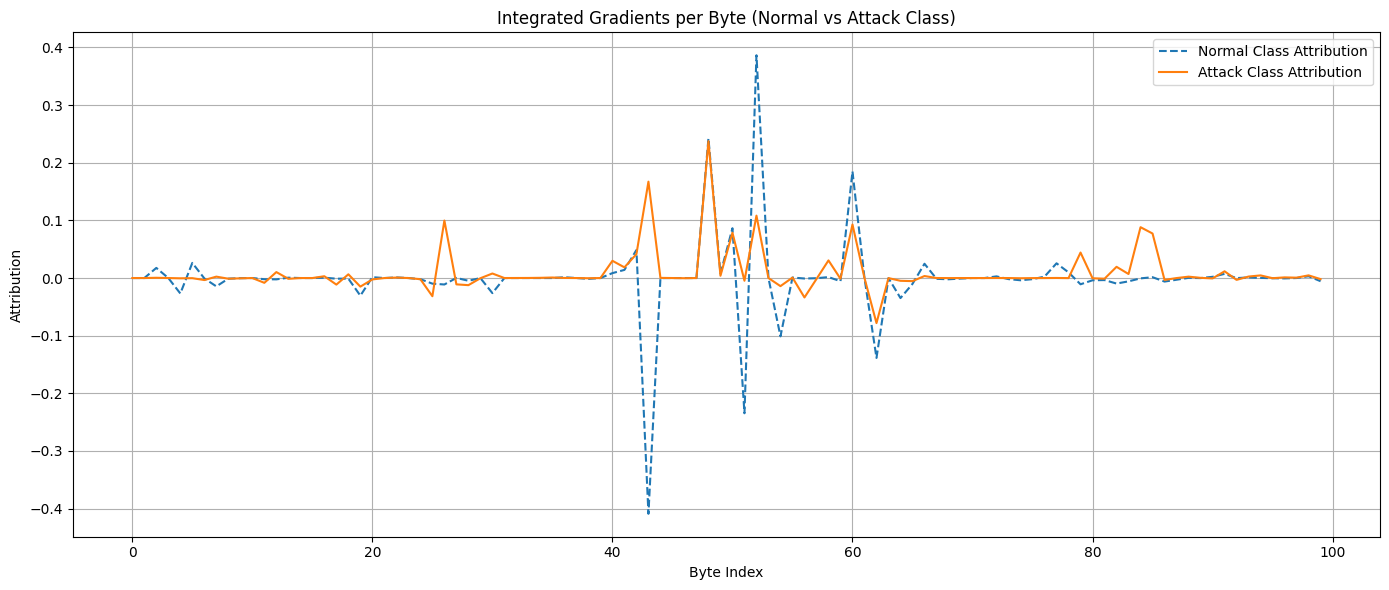

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Baseline - mean

In [28]:
# mean of normal test samples as a baseline
normal_mean = np.mean(X_normal_test, axis=0)
baseline_tensor = tf.convert_to_tensor([normal_mean], dtype=tf.float32)

normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=3000, baseline=baseline_tensor)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000, baseline=baseline_tensor)


In [29]:
# Average IG
avg_normal_mean_ig = np.mean(normal_attributions, axis=0)
avg_attack_mean_ig = np.mean(attack_attributions, axis=0)

In [30]:
# Normal
df_normal_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_mean_ig)),
    "Attribution (Normal Class)": avg_normal_mean_ig
})
df_normal_mean["Abs Attribution"] = np.abs(df_normal_mean["Attribution (Normal Class)"])
df_normal_mean_sorted = df_normal_mean.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_mean_ig)),
    "Attribution (Attack Class)": avg_attack_mean_ig
})
df_attack_mean["Abs Attribution"] = np.abs(df_attack_mean["Attribution (Attack Class)"])
df_attack_mean_sorted = df_attack_mean.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_mean_sorted.head(20), df_attack_mean_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 52          52                    0.864191         0.864191
 43          43                   -0.789160         0.789160
 62          62                   -0.484442         0.484442
 51          51                   -0.427436         0.427436
 49          49                    0.419192         0.419192
 60          60                    0.248369         0.248369
 54          54                    0.142205         0.142205
 30          30                   -0.118927         0.118927
 36          36                   -0.080992         0.080992
 91          91                    0.079871         0.079871
 64          64                    0.078533         0.078533
 48          48                    0.067695         0.067695
 26          26                    0.052311         0.052311
 56          56                   -0.047071         0.047071
 50          50                    0.045115         0.045115
 42          42         

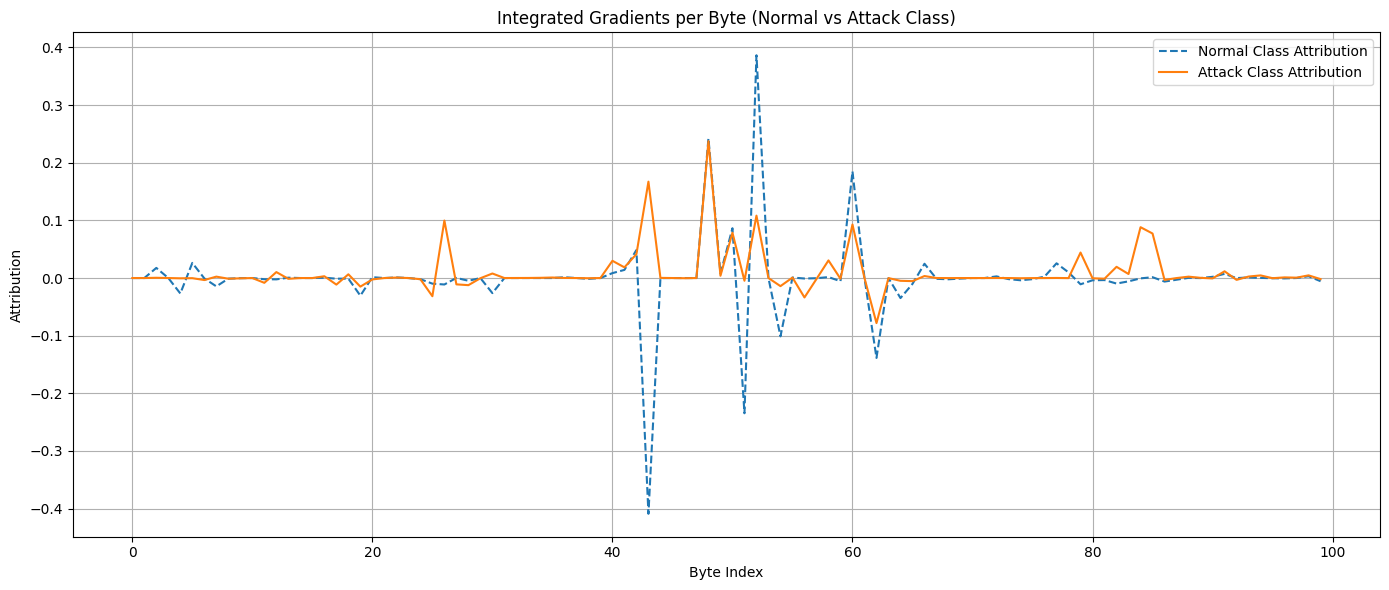

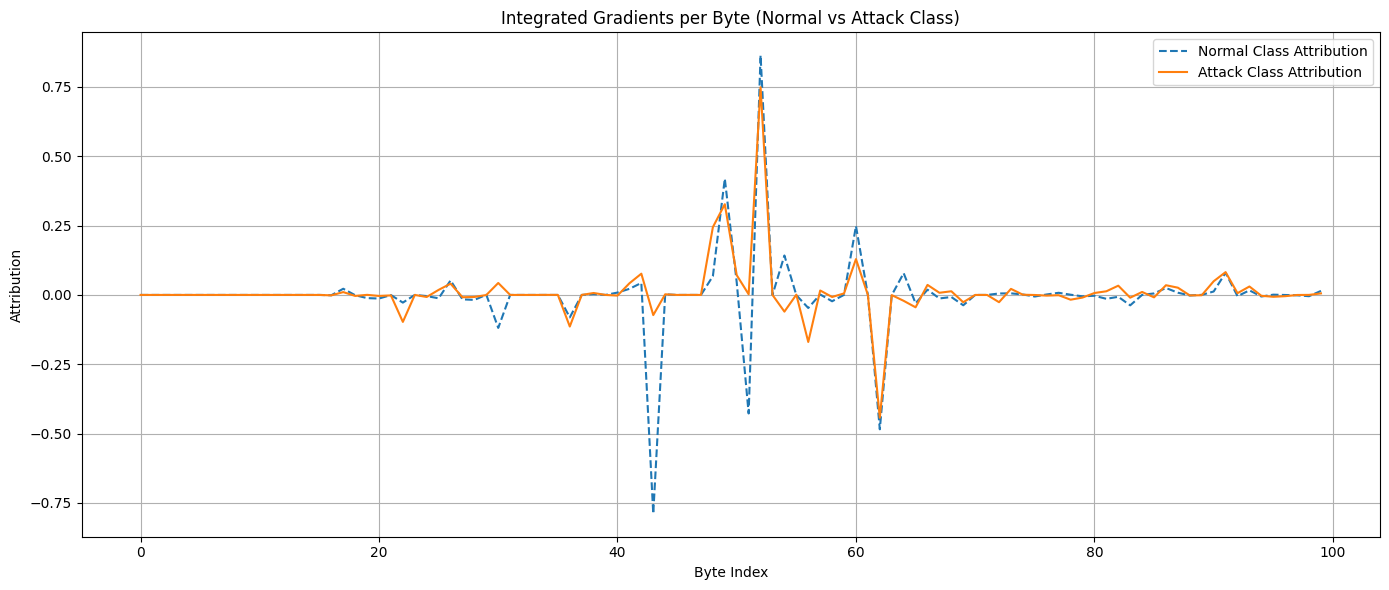

In [31]:
import matplotlib.pyplot as plt
# baseline [0..0]
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# baseline mean
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_mean_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_mean_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:
from collections import Counter, defaultdict
from scapy.all import *
from scapy.layers.dot11 import RadioTap, Dot11, Dot11QoS, LLC #, SNAP
from scapy.layers.inet import SNAP   

def radiotap_len(pkt):
    if pkt.haslayer(RadioTap):
        rt = pkt[RadioTap]
        try:
            return int(rt.len) if rt.len is not None else len(bytes(rt))
        except Exception:
            return len(bytes(rt))
    return 0

def dot11_segments(pkt, base_off=0):
    """
    Return a list of (start, end_exclusive, label, getter) for the Dot11 header
    (addresses, seq ctrl, QoS, etc.). `base_off` is the start offset of Dot11
    within the whole packet (i.e., after Radiotap if present).
    """
    segs = []
    if not pkt.haslayer(Dot11):
        return segs

    d11 = pkt[Dot11]
    cur = base_off

    # Frame Control (2), Duration/ID (2)
    segs.append((cur, cur+2, "Dot11.FrameControl", lambda p: None)); cur += 2
    segs.append((cur, cur+2, "Dot11.DurationID", lambda p: None));   cur += 2

    # Addr1, Addr2, Addr3
    segs.append((cur, cur+6, "Dot11.Addr1", lambda p: p[Dot11].addr1)); cur += 6
    segs.append((cur, cur+6, "Dot11.Addr2", lambda p: p[Dot11].addr2)); cur += 6
    segs.append((cur, cur+6, "Dot11.Addr3", lambda p: p[Dot11].addr3)); cur += 6

    # Sequence Control (2)
    segs.append((cur, cur+2, "Dot11.SeqCtrl", lambda p: getattr(p[Dot11], "SC", None))); cur += 2

    # Addr4 present if ToDS & FromDS both set
    FC = getattr(d11, "FCfield", 0)
    to_ds   = bool(FC & 0x01)
    from_ds = bool(FC & 0x02)
    if to_ds and from_ds:
        segs.append((cur, cur+6, "Dot11.Addr4", lambda p: getattr(p[Dot11], "addr4", None)))
        cur += 6

    # QoS Control (2) if QoS subtype or Dot11QoS layer present
    qos_present = pkt.haslayer(Dot11QoS) or (d11.type == 2 and d11.subtype in (8,9,10,11,12,13,14,15))
    if qos_present:
        segs.append((cur, cur+2, "Dot11.QoS", lambda p: p[Dot11QoS].fields if p.haslayer(Dot11QoS) else None))
        cur += 2

    # HT Control (4) if Order bit set (0x80) in FC
    order_bit = bool(FC & 0x80)
    if order_bit:
        segs.append((cur, cur+4, "Dot11.HTControl", lambda p: None))
        cur += 4

    return segs

def llc_snap_segments(pkt, base_off):
    segs = []
    if pkt.haslayer(LLC):
        # LLC (3 bytes) + SNAP (5 bytes) if SNAP present
        segs.append((base_off, base_off+3, "LLC", lambda p: (p[LLC].dsap, p[LLC].ssap, p[LLC].ctrl)))
        base_off += 3
        if pkt.haslayer(SNAP):
            segs.append((base_off, base_off+3, "SNAP.OUI", lambda p: p[SNAP].OUI))
            segs.append((base_off+3, base_off+5, "SNAP.PID", lambda p: p[SNAP].code))
            base_off += 5
    return segs

def segments_for_packet(pkt):
    """
    Build coarse segments for: Radiotap header, 802.11 header fields, LLC/SNAP, and the rest.
    Returns list of (start, end_exclusive, label, getter).
    """
    segs = []
    rawlen = len(bytes(pkt))

    # Radiotap
    rt_len = radiotap_len(pkt)
    if rt_len > 0:
        segs.append((0, rt_len, "RadioTap.Header", lambda p: None))

    # 802.11 header fields
    segs.extend(dot11_segments(pkt, base_off=rt_len))

    # LLC/SNAP (right after Dot11 header/QoS/HT if present)
    # Determine where Dot11 header we built ends:
    d11_end = max((end for start, end, label, _ in segs if label.startswith("Dot11")), default=rt_len)
    segs.extend(llc_snap_segments(pkt, base_off=d11_end))

    # If payload is encrypted, mark the rest as encrypted
    if pkt.haslayer(Dot11):
        FC = getattr(pkt[Dot11], "FCfield", 0)
        if FC & 0x40:  # Protected
            segs.append((len(bytes(pkt)) - (4 if pkt.lastlayer().name == "Dot11FCS" else 0),
                         rawlen, "Dot11.EncryptedTail/MaybeFCS", lambda p: None))
        else:
            # Mark remaining bytes as payload (best-effort)
            header_end = max((end for start, end, _, _ in segs), default=0)
            if header_end < rawlen:
                segs.append((header_end, rawlen, "Payload/NextLayer", lambda p: None))
    else:
        # Non-802.11 fallback: just mark remaining bytes as payload
        header_end = max((end for start, end, _, _ in segs), default=0)
        if header_end < rawlen:
            segs.append((header_end, rawlen, "Payload/NextLayer", lambda p: None))

    # Coalesce/clip to rawlen just in case
    clipped = []
    for s, e, lab, g in segs:
        s = max(0, min(s, rawlen))
        e = max(0, min(e, rawlen))
        if e > s:
            clipped.append((s, e, lab, g))

    clipped.sort(key=lambda t: t[0])
    return clipped

def field_covering_offset(pkt, offset0):
    """
    Given a packet and a 0-based byte offset from the start of the captured frame,
    return (label, value, start, end_exclusive) if that offset falls within a known segment.
    """
    for s, e, lab, getter in segments_for_packet(pkt):
        if s <= offset0 < e:
            val = None
            try:
                val = getter(pkt) if getter is not None else None
            except Exception:
                val = None
            return lab, val, s, e
    return None, None, None, None

def offset_field_stats(packets, offset, sample_max=5):
    """
    For a list of packets, compute which header field spans the given offset.
    Returns a Counter of labels and example values per label.
    """
    counts = Counter()
    examples = defaultdict(list)
    for pkt in packets:
        lab, val, s, e = field_covering_offset(pkt, offset)
        if lab is None:
            lab = "Unknown/OutOfRange"
        counts[lab] += 1
        if len(examples[lab]) < sample_max:
            examples[lab].append({"range": (s, e), "value": val})
    return counts, dict(examples)


# For "18th byte" 1-based, use offset=17 instead.
offset = 26
counts, examples = offset_field_stats(packets_attack_test, offset=offset)

print("=== Field covering byte offset 18 (0-based) ===")
for lab, cnt in counts.most_common():
    print(f"{lab:28s} : {cnt}")

print("\nExamples:")
for lab, exs in examples.items():
    print(f"\n{lab}")
    for ex in exs:
        print(f"  span={ex['range']}, value={ex['value']}")


=== Field covering byte offset 18 (0-based) ===
RadioTap.Header              : 66475

Examples:

RadioTap.Header
  span=(0, 56), value=None
  span=(0, 56), value=None
  span=(0, 56), value=None
  span=(0, 56), value=None
  span=(0, 56), value=None


In [97]:
import struct
from collections import Counter, defaultdict

# ---- Radiotap field layout (bit -> (name, size, alignment)) ----
# Common, widely used fields
RT_FIELDS = {
    0:  ("TSFT",                 8, 8),
    1:  ("Flags",                1, 1),
    2:  ("Rate",                 1, 1),
    3:  ("Channel",              4, 2),   # 2 bytes freq + 2 bytes flags
    4:  ("FHSS",                 2, 1),
    5:  ("dBm_AntSignal",        1, 1),
    6:  ("dBm_AntNoise",         1, 1),
    7:  ("Lock_Quality",         2, 2),
    8:  ("Tx_Attenuation",       2, 2),
    9:  ("dB_Tx_Attenuation",    2, 2),
    10: ("dBm_Tx_Power",         1, 1),
    11: ("Antenna",              1, 1),
    12: ("dB_AntSignal",         1, 1),
    13: ("dB_AntNoise",          1, 1),
    14: ("Rx_Flags",             2, 2),
    15: ("Tx_Flags",             2, 2),
    # Extras you’ll often see
    19: ("MCS",                  3, 1),
    20: ("A_MPDU_Status",        8, 4),
    21: ("VHT",                 12, 2),
    # Unknown bits (namespaces, vendor, HE, etc.) will be labeled generically
}

# Bit names inside the 1-byte Radiotap Flags field (bit # within that byte)
RT_FLAGS_BITS = {
    0: "CFP",
    1: "Short Preamble",   # 0 => Long preamble
    2: "WEP",
    3: "Fragmentation",
    4: "FCS at end",
    5: "Data Pad",
    6: "Bad FCS",
    7: "Short GI",
}

def _align(off, align):
    if align <= 1: return off
    return (off + (align - 1)) & ~(align - 1)

def _parse_present_words(raw, base=4):
    """Return ([present_words], fields_start_offset)."""
    words = []
    pos = base
    while True:
        if pos + 4 > len(raw): break
        w = struct.unpack_from("<I", raw, pos)[0]
        words.append(w)
        pos += 4
        if (w & 0x80000000) == 0:
            break  # last present word (no 'ext' bit)
    return words, pos

def radiotap_segments_from_bytes(raw, base=0):
    """
    Build detailed segments for the Radiotap header at 'base'.
    Returns list of dicts: {start, end, label, info}
    """
    segs = []
    if len(raw) < base + 4:
        return segs

    ver = raw[base + 0]
    pad = raw[base + 1]
    rt_len = struct.unpack_from("<H", raw, base + 2)[0]

    segs.append({"start": base + 0, "end": base + 1, "label": "Radiotap.version", "info": ver})
    segs.append({"start": base + 1, "end": base + 2, "label": "Radiotap.pad",     "info": pad})
    segs.append({"start": base + 2, "end": base + 4, "label": "Radiotap.len",     "info": rt_len})

    # Present bitmaps (with possible extensions)
    present_words, fields_start = _parse_present_words(raw, base + 4)
    for i, w in enumerate(present_words):
        segs.append({
            "start": base + 4 + 4*i,
            "end":   base + 8 + 4*i,
            "label": f"Radiotap.present[{i}]",
            "info":  w
        })

    # Walk variable fields in numeric-bit order with alignment
    off = fields_start
    ns_base = 0  # 0 for base namespace; this example ignores vendor sub-namespaces

    bit_base = 0
    for wi, w in enumerate(present_words):
        for b in range(32):
            # b==31 means 'Ext' in present words, not a payload field
            if b == 31: 
                continue
            if not (w & (1 << b)):
                continue

            bit_idx = bit_base + b
            name, size, align = RT_FIELDS.get(bit_idx, (f"Unknown_or_Namespace(bit{bit_idx})", None, 1))

            if size is None:
                # We don't know this field's size — stop mapping further fields
                # (Otherwise offsets for later fields could be wrong.)
                segs.append({"start": off, "end": off, "label": name, "info": None})
                # We’ll just mark the rest of the radiotap blob as unknown
                endcap = base + rt_len
                if endcap > off:
                    segs.append({"start": off, "end": endcap, "label": "Radiotap.UnparsedTail", "info": None})
                return segs

            off = _align(off, align)

            # Add the field segment; split some compound ones for more precision
            if name == "Channel" and off + 4 <= len(raw):
                segs.append({"start": off, "end": off+2, "label": "Radiotap.Channel.frequency",
                             "info": struct.unpack_from("<H", raw, off)[0]})
                segs.append({"start": off+2, "end": off+4, "label": "Radiotap.Channel.flags",
                             "info": struct.unpack_from("<H", raw, off+2)[0]})
            elif name == "Flags" and off + 1 <= len(raw):
                byte = raw[off]
                flags_info = {lbl: bool(byte & (1 << k)) for k, lbl in RT_FLAGS_BITS.items()}
                flags_info["_raw"] = byte
                segs.append({"start": off, "end": off+1, "label": "Radiotap.Flags", "info": flags_info})
            else:
                # Generic field
                segs.append({"start": off, "end": off + size, "label": f"Radiotap.{name}", "info": None})
            off += size

        bit_base += 32

    # Safety: cap to rt_len if overread
    endcap = base + rt_len
    for s in segs:
        s["start"] = max(base, min(s["start"], endcap))
        s["end"]   = max(s["start"], min(s["end"],   endcap))

    return sorted(segs, key=lambda d: d["start"])

def radiotap_field_covering_offset(pkt, offset):
    """
    Return the most specific Radiotap sub-field covering 'offset0'.
    """
    raw = bytes(pkt)
    segs = radiotap_segments_from_bytes(raw, base=0)
    for seg in segs:
        if seg["start"] <= offset < seg["end"]:
            return seg
    # Not inside Radiotap (or out of range)
    return None

# ---- Convenience: stats over a packet list
def offset_radiotap_stats(packets, offset=18, sample_max=5):
    counts = Counter()
    examples = defaultdict(list)
    for pkt in packets:
        seg = radiotap_field_covering_offset(pkt, offset)
        label = seg["label"] if seg else "Not in Radiotap / Unknown"
        counts[label] += 1
        if seg and len(examples[label]) < sample_max:
            examples[label].append({"range": (seg["start"], seg["end"]), "info": seg["info"]})
    return counts, dict(examples)

# Example usage:
# seg = radiotap_field_covering_offset(packets_attack[0], offset=76)
# print(seg["label"], seg["range"] if "range" in seg else (seg["start"], seg["end"]), seg["info"])
counts, examples = offset_radiotap_stats(packets_attack_test, offset=42)
print(counts)
print(examples)


Counter({'Radiotap.UnparsedTail': 59109, 'Radiotap.VHT': 7366})
{'Radiotap.UnparsedTail': [{'range': (38, 56), 'info': None}, {'range': (34, 56), 'info': None}, {'range': (34, 56), 'info': None}, {'range': (34, 56), 'info': None}, {'range': (34, 56), 'info': None}], 'Radiotap.VHT': [{'range': (36, 48), 'info': None}, {'range': (36, 48), 'info': None}, {'range': (36, 48), 'info': None}, {'range': (36, 48), 'info': None}, {'range': (36, 48), 'info': None}]}


In [43]:
packets_attack[:1]

[<RadioTap  version=0 pad=0 len=64 present=Flags+Channel+dBm_AntSignal+RXFlags+A_MPDU+VHT+timestamp+RadiotapNS+Ext Ext=[<RadioTapExtendedPresenceMask  present=b5+b11+b29+Ext |>, <RadioTapExtendedPresenceMask  present=b37+b43 |>] Flags=FCS ChannelFrequency=5180 ChannelFlags=OFDM+5GHz dBm_AntSignal=-31 dBm RXFlags= A_MPDU_ref=0 A_MPDU_flags= KnownVHT=STBC+GuardInterval+Beamformed+Bandwidth PresentVHT= VHT_bandwidth=20MHz mcs_nss=b'\x82\x00\x00\x00\x01' GroupID=0 PartialAID=0 timestamp=2059461796 ts_accuracy=22 ts_unit=microseconds ts_position=1 ts_flags=32-bit_counter+Accuracy notdecoded=b'\xd8\x00\xe1\x01' |<Dot11FCS  subtype=QoS Data type=Data proto=0 FCfield=from-DS+protected ID=12288 addr1=00:00:00:00:00:00 (RA=DA) addr2=00:00:00:00:00:00 (TA=BSSID) addr3=00:00:00:00:00:00 (SA) SC=480 fcs=0xeef11e27 |<Dot11QoS  A_MSDU_Present=0 Ack_Policy=0 EOSP=0 TID=0 TXOP=0 |<Dot11CCMP  PN0=17 PN1=0 res0=0 key_id=0 ext_iv=1 res1=0 PN2=0 PN3=0 PN4=0 PN5=0 data=b'\xab\xb0b\xbf>\xcb[\x91B\xf8\xc0A\xd

In [46]:
from scapy.all import Dot11
from collections import Counter

# Mapping of (type, subtype) -> human-readable names
dot11_subtypes = {
    (0, 0): "Association Request",
    (0, 1): "Association Response",
    (0, 2): "Reassociation Request",
    (0, 3): "Reassociation Response",
    (0, 4): "Probe Request",
    (0, 5): "Probe Response",
    (0, 8): "Beacon",
    (0, 9): "ATIM",
    (0, 10): "Disassociation",
    (0, 11): "Authentication",
    (0, 12): "Deauthentication",
    (0, 13): "Action",
    (1, 10): "PS-Poll",
    (1, 11): "RTS",
    (1, 12): "CTS",
    (1, 13): "ACK",
    (1, 14): "CF-End",
    (1, 15): "CF-End + CF-Ack",
    (2, 0): "Data",
    (2, 4): "Null Data",
    (2, 8): "QoS Data",
    (2, 12): "QoS Null Data"
}

# Count subtype values
subtype_counts = Counter()

for pkt in packets_attack[:1000]:
    if pkt.haslayer(Dot11):
        pkt_type = pkt.type
        pkt_subtype = pkt.subtype
        subtype_counts[(pkt_type, pkt_subtype)] += 1

# Print results
for (pkt_type, pkt_subtype), count in subtype_counts.items():
    name = dot11_subtypes.get((pkt_type, pkt_subtype), f"Unknown (type={pkt_type}, subtype={pkt_subtype})")
    print(f"{name}: {count}")


QoS Data: 1000


# FGSM

In [47]:
# Original full packets for those test attack samples
attack_test_mask = y_test == 1
X_attack_test = X_test[attack_test_mask].squeeze(axis=-1)
y_attack_test = y_test[attack_test_mask]
idx_attack_test = idx_test[attack_test_mask]

# Map test indices back to attack-only packets
# All attack packets are offset by len(X_normal)
relative_attack_indices = idx_attack_test - attack_start_idx
packets_attack_test = [packets_attack[i] for i in relative_attack_indices]

In [48]:
X_test_normal = X_test[y_test == 0]
y_test_normal = y_test[y_test == 0]

X_test_attack = X_test[y_test == 1]
y_test_attack = y_test[y_test == 1]

In [49]:
# Separate test samples
X_normal_test = X_test[y_test == 0]
X_attack_test = X_test[y_test == 1]

In [50]:
def fgsm_attack(model, x, y_true, epsilon=0.01):
    x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        prediction = model(x_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, prediction)

    # Compute gradients
    gradient = tape.gradient(loss, x_adv)
    signed_grad = tf.sign(gradient)

    # Apply perturbation
    x_adv = x_adv + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # to keep values in byte range

    return x_adv


In [51]:
# Generate adversarial samples
X_test_attack_adv = fgsm_attack(model, X_test_attack, y_attack_test, epsilon=0.2)

In [52]:
from scapy.all import Ether, wrpcap
from scapy.layers.dot11 import RadioTap, Dot11
from scapy.layers.inet import IP, TCP, UDP, ICMP
from scapy.layers.inet6 import IPv6, ICMPv6EchoRequest, ICMPv6EchoReply

def _fix_checksums(pkt):
    """
    Recompute common L3/L4 checksums and lengths where possible.
    (No 802.11 FCS recalculation here; most captures don't include it.)
    """
    ip = pkt.getlayer(IP)
    ip6 = pkt.getlayer(IPv6)

    if ip:
        # Recompute IPv4 header length & checksum
        for f in ("len", "chksum"):
            if hasattr(ip, f):
                try: delattr(ip, f)
                except Exception: pass
        # Recompute transports
        tcp = pkt.getlayer(TCP)
        if tcp and hasattr(tcp, "chksum"):
            del tcp.chksum
        udp = pkt.getlayer(UDP)
        if udp and hasattr(udp, "chksum"):
            del udp.chksum
        icmp = pkt.getlayer(ICMP)
        if icmp and hasattr(icmp, "chksum"):
            del icmp.chksum

    elif ip6:
        # IPv6 has no header checksum; just transports
        tcp = pkt.getlayer(TCP)
        if tcp and hasattr(tcp, "chksum"):
            del tcp.chksum
        udp = pkt.getlayer(UDP)
        if udp and hasattr(udp, "chksum"):
            del udp.chksum
        for ic6 in (ICMPv6EchoRequest, ICMPv6EchoReply):
            l = pkt.getlayer(ic6)
            if l and hasattr(l, "cksum"):
                del l.cksum

    # Force Scapy to rebuild the packet bytes with new checksums, then reparse
    top = RadioTap if pkt.haslayer(RadioTap) else (Dot11 if pkt.haslayer(Dot11) else Ether)
    return top(bytes(pkt))


def _parse_like_original(raw_bytes, original_pkt):
    """
    Rebuild using the same top-level layer as original, to preserve pcap linktype.
    """
    if original_pkt.haslayer(RadioTap):
        return RadioTap(raw_bytes)
    if original_pkt.haslayer(Dot11):
        return Dot11(raw_bytes)
    return Ether(raw_bytes)  # fallback


def patch_full_packet_bytes(pkt, fgsm_bytes, skip_radiotap=True):
    """
    Replace bytes of a packet with FGSM output.
    For Wi-Fi frames, by default we start after the Radiotap header.
    """
    raw = bytearray(bytes(pkt))
    fgsm_bytes = bytes(fgsm_bytes)

    # Determine start offset (skip Radiotap for Wi-Fi, if present)
    start = 0
    if skip_radiotap and pkt.haslayer(RadioTap):
        rt = pkt[RadioTap]
        # Radiotap has a 'len' field indicating its header length
        try:
            start = int(rt.len) if rt.len is not None else len(bytes(rt))
        except Exception:
            start = len(bytes(rt))

    # Only overwrite up to what's available
    n = min(len(raw) - start, len(fgsm_bytes))
    if n <= 0:
        return None
    raw[start:start + n] = fgsm_bytes[:n]

    try:
        new_pkt = _parse_like_original(bytes(raw), pkt)

        # If the 802.11 Protected bit is set, payload is encrypted — nothing to fix.
        if new_pkt.haslayer(Dot11) and (getattr(new_pkt[Dot11], "FCfield", 0) & 0x40):
            return new_pkt

        return _fix_checksums(new_pkt)
    except Exception:
        return None


def save_fgsm_patched_full_packets(original_packets, x_adv_uint8, output_path, skip_radiotap=True):
    """
    Writes a pcap whose linktype matches the first packet (RadioTap/Dot11/Ethernet).
    """
    patched = []
    for orig_pkt, adv_bytes in zip(original_packets, x_adv_uint8):
        pkt = patch_full_packet_bytes(orig_pkt, adv_bytes, skip_radiotap=skip_radiotap)
        if pkt:
            patched.append(pkt)
    if patched:
        wrpcap(output_path, patched)
    print(f"✅ Saved {len(patched)} FGSM-modified packets to {output_path}")


In [71]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_adv.numpy() * 255).astype(np.uint8)
print(len(packets_attack_test))

save_fgsm_patched_full_packets(packets_attack_test, x_adv_uint8, "awid_fgsm_full_modified_anon.pcap")

66475
✅ Saved 66475 FGSM-modified packets to awid_fgsm_full_modified_anon.pcap


In [72]:
from scapy.utils import wrpcap

wrpcap("attack_out.pcap", packets_attack_test)


In [54]:
X_test = np.vstack((X_test_normal, X_test_attack_adv))
y_test = np.hstack((y_test_normal, y_attack_test))

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

13568/13568 ━━━━━━━━━━━━━━━━━━━━ 14s 995us/step
Accuracy: 0.86
Precision: 0.99
Recall: 0.06


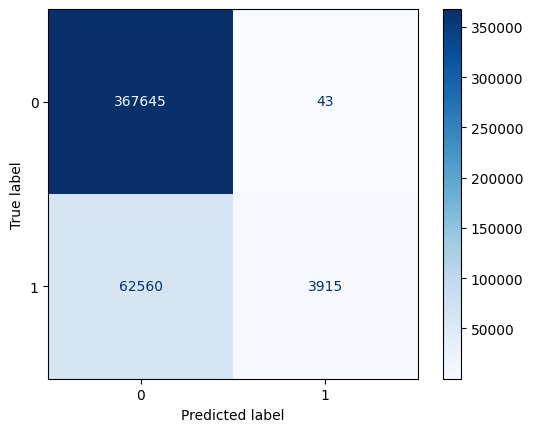

                precision    recall  f1-score   support

Normal Traffic       0.85      1.00      0.92    367688
        Attack       0.99      0.06      0.11     66475

      accuracy                           0.86    434163
     macro avg       0.92      0.53      0.52    434163
  weighted avg       0.88      0.86      0.80    434163



In [56]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

# FGSM - targeted byte positions only

In [126]:
import tensorflow as tf

def fgsm_attack_valid80211(model, x, y_true, epsilon=1.0/255.0,
                           idx_fc0=56, idx_seq_lo=78, idx_seq_hi=79):
    """
    x: float32 [B, L] or [B, L, 1], bytes normalized to [0,1]
    y_true: [B] or [B,1]
    Only bytes 56 (FC[0]) and 78..79 (Sequence Control) are perturbed.
    """

    x = tf.convert_to_tensor(x, tf.float32)
    y_true = tf.cast(tf.reshape(y_true, (-1, 1)), tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        loss = tf.keras.losses.binary_crossentropy(y_true, pred)

    grad = tape.gradient(loss, x)

    # --- Mask perturbation to target bytes only ---
    L = tf.shape(x)[1]
    mask1d = (tf.one_hot(idx_fc0, L, dtype=tf.float32) +
              tf.one_hot(idx_seq_lo, L, dtype=tf.float32) +
              tf.one_hot(idx_seq_hi, L, dtype=tf.float32))
    mask = mask1d[None, :] if x.shape.ndims == 2 else mask1d[None, :, None]
    mask = tf.broadcast_to(mask, tf.shape(x))

    # FGSM step (masked) + clip
    x_adv = tf.clip_by_value(x + epsilon * tf.sign(grad) * mask, 0.0, 1.0)

    # === Project to valid 802.11 bytes ===
    xb_adv  = tf.cast(tf.round(x_adv * 255.0), tf.uint16)
    xb_orig = tf.cast(tf.round(x     * 255.0), tf.uint16)

    # Do byte math in 2-D; add channel back at the end if needed
    if xb_adv.shape.ndims == 3:
        xb_adv_2d  = tf.squeeze(xb_adv,  axis=-1)  # [B, L]
        xb_orig_2d = tf.squeeze(xb_orig, axis=-1)  # [B, L]
    else:
        xb_adv_2d, xb_orig_2d = xb_adv, xb_orig

    B = tf.shape(xb_adv_2d)[0]
    bi = tf.range(B, dtype=tf.int32)[:, None]

    # ----- Frame Control first byte (idx_fc0) -----
    fc0_orig_i = tf.cast(xb_orig_2d[:, idx_fc0], tf.int32)
    fc0_new_i  = tf.cast(xb_adv_2d[:,  idx_fc0], tf.int32)

    type_bits = tf.bitwise.right_shift(tf.bitwise.bitwise_and(fc0_orig_i, 0x0C), 2)
    sub_cand  = tf.bitwise.bitwise_and(tf.bitwise.right_shift(fc0_new_i, 4), 0x0F)
    sub_orig  = tf.bitwise.bitwise_and(tf.bitwise.right_shift(fc0_orig_i, 4), 0x0F)

    def allowed_mask(type_bits, sub_orig):
        base = tf.zeros([tf.shape(type_bits)[0], 16], dtype=tf.bool)

        # Type 0 (Mgmt)
        mgmt = tf.equal(type_bits, 0)
        in_10_12 = tf.logical_or(tf.equal(sub_orig, 10), tf.equal(sub_orig, 12))
        allow_mgmt_10_12 = tf.logical_and(mgmt, in_10_12)

        # Helper: add constant subtype set for a row mask
        def add_allowed_constants(base_in, row_mask, values):
            rows = tf.cast(tf.where(row_mask)[:, 0], tf.int32)  # << cast to int32
            for v in values:
                idxs = tf.stack(
                    [rows, tf.fill([tf.shape(rows)[0]], tf.cast(v, tf.int32))],
                    axis=1
                )
                base_in = tf.tensor_scatter_nd_update(
                    base_in, idxs, tf.ones([tf.shape(rows)[0]], dtype=tf.bool)
                )
            return base_in

        # mgmt & not in {10,12}: allow the original subtype per-row (per-row scatter)
        rows_keep = tf.cast(tf.where(tf.logical_and(mgmt, tf.logical_not(in_10_12)))[:, 0], tf.int32)  # << cast
        subs_keep = tf.gather(tf.cast(sub_orig, tf.int32), rows_keep)
        idx_keep  = tf.stack([rows_keep, subs_keep], axis=1)
        base = tf.tensor_scatter_nd_update(
            base, idx_keep, tf.ones([tf.shape(rows_keep)[0]], dtype=tf.bool)
        )

        # mgmt & in {10,12}: allow {10,12}
        base = add_allowed_constants(base, allow_mgmt_10_12, [10, 12])

        # Type 2 (Data)
        data = tf.equal(type_bits, 2)
        nonqos_set = [0, 1, 2, 3, 4, 5, 6, 7]
        qos_set    = [8, 9, 10, 11, 12, 14, 15]  # exclude 13 (reserved)
        is_qos = tf.reduce_any(
            tf.stack([tf.equal(sub_orig, v) for v in [8, 9, 10, 11, 12, 14, 15]], axis=1),
            axis=1
        )
        base = add_allowed_constants(base, tf.logical_and(data, tf.logical_not(is_qos)), nonqos_set)
        base = add_allowed_constants(base, tf.logical_and(data, is_qos), qos_set)

        # Type 1 (Control) or Type 3 (Extension): keep original subtype only (per-row scatter)
        ctrl_or_ext = tf.logical_or(tf.equal(type_bits, 1), tf.equal(type_bits, 3))
        rows_keep2 = tf.cast(tf.where(ctrl_or_ext)[:, 0], tf.int32)  # << cast
        subs_keep2 = tf.gather(tf.cast(sub_orig, tf.int32), rows_keep2)
        idx_keep2  = tf.stack([rows_keep2, subs_keep2], axis=1)
        base = tf.tensor_scatter_nd_update(
            base, idx_keep2, tf.ones([tf.shape(rows_keep2)[0]], dtype=tf.bool)
        )

        return base

    allowed = allowed_mask(tf.cast(type_bits, tf.int32), tf.cast(sub_orig, tf.int32))  # [B,16]

    # Snap candidate subtype to nearest allowed value
    all_vals = tf.range(16, dtype=tf.int32)[None, :]
    diffs = tf.abs(tf.expand_dims(tf.cast(sub_cand, tf.int32), 1) - all_vals)
    big = tf.fill(tf.shape(diffs), tf.constant(10**6, tf.int32))
    diffs = tf.where(allowed, diffs, big)
    sub_snap = tf.cast(tf.argmin(diffs, axis=1), tf.int32)

    low_nibble = tf.bitwise.bitwise_and(fc0_orig_i, 0x0F)
    fc0_proj_i32 = tf.bitwise.bitwise_or(tf.bitwise.left_shift(sub_snap, 4), low_nibble)
    fc0_proj = tf.cast(fc0_proj_i32, xb_adv_2d.dtype)

    xb_adv_2d = tf.tensor_scatter_nd_update(
        xb_adv_2d,
        tf.concat([bi, tf.fill([B, 1], tf.cast(idx_fc0, tf.int32))], axis=1),
        fc0_proj
    )

    # ----- Sequence Control (bytes 78-79): keep Fragment# -----
    lo_new  = xb_adv_2d[:, idx_seq_lo]
    hi_new  = xb_adv_2d[:, idx_seq_hi]
    lo_orig = xb_orig_2d[:, idx_seq_lo]

    seq16_new  = tf.bitwise.bitwise_or(
        tf.bitwise.left_shift(tf.cast(hi_new,  tf.int32), 8),
        tf.cast(lo_new, tf.int32)
    )
    seq16_proj = tf.bitwise.bitwise_or(
        tf.bitwise.bitwise_and(seq16_new, 0xFFF0),
        tf.bitwise.bitwise_and(tf.cast(lo_orig, tf.int32), 0x000F)
    )

    lo_proj = tf.cast(tf.bitwise.bitwise_and(seq16_proj, 0x00FF), xb_adv_2d.dtype)
    hi_proj = tf.cast(tf.bitwise.right_shift(seq16_proj, 8), xb_adv_2d.dtype)

    xb_adv_2d = tf.tensor_scatter_nd_update(
        xb_adv_2d,
        tf.concat([bi, tf.fill([B, 1], tf.cast(idx_seq_lo, tf.int32))], axis=1),
        lo_proj
    )
    xb_adv_2d = tf.tensor_scatter_nd_update(
        xb_adv_2d,
        tf.concat([bi, tf.fill([B, 1], tf.cast(idx_seq_hi, tf.int32))], axis=1),
        hi_proj
    )

    # back to normalized floats; restore channel if input was 3-D
    out = tf.cast(xb_adv_2d, tf.float32) / 255.0
    if x.shape.ndims == 3:
        out = out[..., None]
    return out


In [106]:
X_test_attack.shape

(66475, 100, 1)

In [131]:
# Generate adversarial samples
X_test_attack_adv_valid = fgsm_attack_valid80211(model, X_test_attack, y_attack_test, epsilon=0.2)

print(X_test_attack_adv_valid.shape)  # (66475, 100, 1)


(66475, 100, 1)


In [136]:
from scapy.all import RadioTap, wrpcap
import numpy as np

def patch_packet_with_fgsm_bytes(pkt, fgsm_bytes, target_indices=(5, 78, 79), tolerate_short=True):
    """
    Patch 'pkt' at the given byte offsets using values from 'fgsm_bytes' (normalized [0,1]).
    Only bytes whose value actually changed are written.
    Returns a new Scapy RadioTap packet (or the original pkt if nothing changed).
    If the packet is shorter than an index and 'tolerate_short' is True, that index is skipped.
    """
    # Raw bytes of the original packet (Radiotap + 802.11 …)
    raw = bytearray(bytes(pkt))

    # fgsm_bytes can be shape (100, 1), (100,), or similar — squeeze to 1D length L
    vec = np.asarray(fgsm_bytes, dtype=np.float32).squeeze()
    if vec.ndim != 1:
        raise ValueError(f"fgsm_bytes must be 1-D after squeeze, got shape {vec.shape}")

    # Convert normalized floats to uint8 bytes
    vec_bytes = np.clip(np.rint(vec * 255.0), 0, 255).astype(np.uint8)

    changed = False
    for idx in target_indices:
        if idx < 0:
            continue
        if idx >= len(raw):
            if tolerate_short:
                continue
            else:
                return None
        new_b = int(vec_bytes[idx])
        if raw[idx] != new_b:
            raw[idx] = new_b
            changed = True

    if not changed:
        return pkt  # nothing to update

    # Rebuild as a Radiotap packet so wrpcap keeps linktype 127 (radiotap)
    return RadioTap(bytes(raw))


def save_fgsm_modified_packets(original_packets, fgsm_bytes_array, output_path, target_indices=(5, 78, 79)):
    """
    original_packets: iterable of Scapy packets (Radiotap/802.11)
    fgsm_bytes_array: array-like of shape [B, 100, 1] (normalized [0,1]) aligned with original_packets
    """
    patched_packets = []
    for pkt, fgsm_bytes in zip(original_packets, fgsm_bytes_array):
        patched = patch_packet_with_fgsm_bytes(pkt, fgsm_bytes, target_indices=target_indices)
        if patched is not None:
            patched_packets.append(patched)

    if patched_packets:
        wrpcap(output_path, patched_packets)
        print(f"✅ Saved {len(patched_packets)} FGSM-modified packets to: {output_path}")
    else:
        print("⚠️ No valid packets to save.")


In [137]:
# x_adv_normalized: output of fgsm_attack (normalized)
# x_adv_uint8 = (X_test_attack_adv_valid.numpy() * 255).astype(np.uint8)
print(len(packets_attack_test))

save_fgsm_modified_packets(
    original_packets=packets_attack_test,
    fgsm_bytes_array=X_test_attack_adv_valid,   # pass as-is; function handles squeezing
    output_path=r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\awid_fgsm_valid.pcap",
    target_indices=(56, 78, 79)
)

# save_fgsm_patched_full_packets(packets_attack_test, x_adv_uint8, r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\awid_fgsm_valid.pcap")

66475
✅ Saved 66475 FGSM-modified packets to: C:\Users\ulami\Desktop\datasety\AWID3_pcap\awid_fgsm_valid.pcap


In [132]:
X_test = np.vstack((X_test_normal, X_test_attack_adv_valid))
y_test = np.hstack((y_test_normal, y_attack_test))

In [133]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

13568/13568 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.98


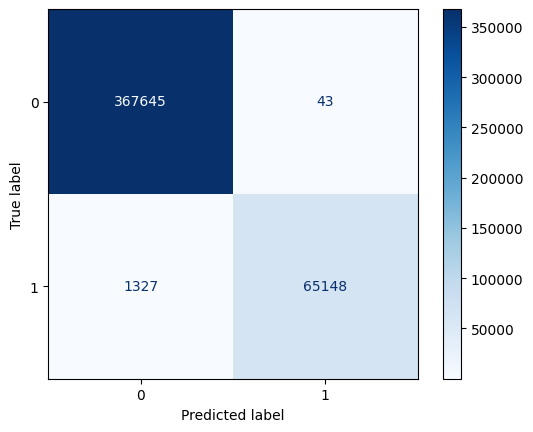

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    367688
        Attack       1.00      0.98      0.99     66475

      accuracy                           1.00    434163
     macro avg       1.00      0.99      0.99    434163
  weighted avg       1.00      1.00      1.00    434163



In [134]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

# ZOO ATTACK

In [1]:
import numpy as np
import tensorflow as tf

def _bce_loss_from_logits_or_probs(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def _model_loss(model, x, y_true, targeted=False, y_target=None):
    x_tensor = tf.convert_to_tensor(x[None, ...], dtype=tf.float32)  # shape (1,H,W,1)
    pred = model(x_tensor)

    if targeted:
        if y_target is None:
            raise ValueError("y_target must be provided for targeted=True")
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_target)]], dtype=tf.float32), pred)
        # targeted: minimize loss toward y_target
        return loss[0]
    else:
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_true)]], dtype=tf.float32), pred)
        # untargeted: maximize loss w.r.t true label -> return +loss
        return loss[0]

def _zoo_estimate_grad(model, x, y_true, coords, fd_eta, targeted=False, y_target=None):
    """
    Symmetric finite-difference gradient estimate on selected flat coords.
    Supports ANY x shape (e.g., (L,1), (L,), (H,W), (H,W,C)).
    Returns grad_est with same shape as x (np.float32).
    """
    x = x.astype(np.float32, copy=True)
    orig_shape = x.shape

    x_flat = x.reshape(-1)
    grad_flat = np.zeros_like(x_flat, dtype=np.float32)

    for idx in coords:
        orig = x_flat[idx]

        # +eta
        x_flat[idx] = np.clip(orig + fd_eta, 0.0, 1.0)
        f_plus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # -eta
        x_flat[idx] = np.clip(orig - fd_eta, 0.0, 1.0)
        f_minus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # restore
        x_flat[idx] = orig

        grad_flat[idx] = (f_plus - f_minus) / (2.0 * fd_eta)

    return grad_flat.reshape(orig_shape)

def zoo_attack(
    model,
    x,
    y_true,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng=None,
    verbose=False
):
    """
    ZOO attack for a single sample x with ANY shape (e.g., (L,1) for Conv1D).
    L_inf constraint with radius epsilon around original x.
    """
    if rng is None:
        rng = np.random.default_rng()

    x0 = x.astype(np.float32).copy()
    x_adv = x0.copy()

    flat_len = x_adv.size
    all_coords = np.arange(flat_len)

    for t in range(iters):
        coords = rng.choice(all_coords, size=min(coord_batch, flat_len), replace=False)

        g = _zoo_estimate_grad(model, x_adv, y_true, coords, fd_eta, targeted=targeted, y_target=y_target)

        # Make sparse update only on sampled coords (optional)
        if coord_batch < flat_len:
            mask = np.zeros(flat_len, dtype=np.float32)
            mask[coords] = 1.0
            g = (g.reshape(-1) * mask).reshape(x_adv.shape)

        step = -lr * np.sign(g) if targeted else lr * np.sign(g)
        x_adv = x_adv + step

        # Project to L_inf ball around x0 and clip to [0,1]
        x_adv = np.clip(x_adv, x0 - epsilon, x0 + epsilon)
        x_adv = np.clip(x_adv, 0.0, 1.0)

        if verbose and (t % max(1, iters // 10) == 0 or t == iters - 1):
            current_loss = float(_model_loss(model, x_adv, y_true, targeted, y_target))
            print(f"[ZOO] iter {t+1}/{iters} | loss={current_loss:.6f}")

    return x_adv.astype(np.float32)


from tqdm import tqdm

def zoo_attack_batch(
    model,
    X,
    y,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng_seed=42,
    verbose_every=0
):
    """
    Batched convenience wrapper over zoo_attack with tqdm progress bar.
    X: (N,H,W,1) in [0,1]
    y: (N,) in {0,1}
    Returns X_adv of same shape.
    """
    rng = np.random.default_rng(rng_seed)
    X_adv = np.empty_like(X, dtype=np.float32)
    N = X.shape[0]

    for i in tqdm(range(N), desc="ZOO attack samples"):
        ve = (verbose_every and ((i % verbose_every) == 0))
        X_adv[i] = zoo_attack(
            model,
            X[i],
            float(y[i]),
            epsilon=epsilon,
            iters=iters,
            fd_eta=fd_eta,
            lr=lr,
            coord_batch=coord_batch,
            targeted=targeted,
            y_target=(int(y_target) if y_target is not None else None),
            rng=rng,
            verbose=ve
        )
    return X_adv

In [82]:

X_test_attack_zoo = zoo_attack_batch(
    model,
    X_test_attack[:200],        # shape (N, 100, 1, 1) or (N, 100, 1) depending on your reshape
    y_test_attack[:200],        # vector of 1s for attack samples
    epsilon=0.2,
    iters=20,            # increase for stronger attacks (but more queries)
    fd_eta=1e-3,
    lr=0.1,
    coord_batch=248,      # number of coordinates probed per iter
    targeted=False,
    y_target=None,
    rng_seed=123,
    verbose_every=30
)

ZOO attack samples:   0%|          | 0/200 [00:00<?, ?it/s]

[ZOO] iter 1/20 | loss=24.566748
[ZOO] iter 3/20 | loss=28.075357
[ZOO] iter 5/20 | loss=37.925610
[ZOO] iter 7/20 | loss=37.047359
[ZOO] iter 9/20 | loss=37.433331
[ZOO] iter 11/20 | loss=35.295410
[ZOO] iter 13/20 | loss=40.982155
[ZOO] iter 15/20 | loss=40.048271
[ZOO] iter 17/20 | loss=30.960236
[ZOO] iter 19/20 | loss=35.454391
[ZOO] iter 20/20 | loss=33.530579


ZOO attack samples:  15%|█▌        | 30/200 [12:00<1:06:44, 23.56s/it]

[ZOO] iter 1/20 | loss=26.631607
[ZOO] iter 3/20 | loss=31.883837
[ZOO] iter 5/20 | loss=46.713528
[ZOO] iter 7/20 | loss=41.840218
[ZOO] iter 9/20 | loss=37.464657
[ZOO] iter 11/20 | loss=45.787758
[ZOO] iter 13/20 | loss=48.227566
[ZOO] iter 15/20 | loss=51.217999
[ZOO] iter 17/20 | loss=49.089405
[ZOO] iter 19/20 | loss=50.808285
[ZOO] iter 20/20 | loss=41.821495


ZOO attack samples:  30%|███       | 60/200 [23:58<55:36, 23.83s/it]  

[ZOO] iter 1/20 | loss=23.139078
[ZOO] iter 3/20 | loss=32.294743
[ZOO] iter 5/20 | loss=34.057358
[ZOO] iter 7/20 | loss=32.921818
[ZOO] iter 9/20 | loss=38.151855
[ZOO] iter 11/20 | loss=30.110628
[ZOO] iter 13/20 | loss=40.280415
[ZOO] iter 15/20 | loss=39.439732
[ZOO] iter 17/20 | loss=35.537094
[ZOO] iter 19/20 | loss=35.351017
[ZOO] iter 20/20 | loss=41.798973


ZOO attack samples:  45%|████▌     | 90/200 [35:37<42:24, 23.13s/it]

[ZOO] iter 1/20 | loss=20.917536
[ZOO] iter 3/20 | loss=33.504459
[ZOO] iter 5/20 | loss=41.670864
[ZOO] iter 7/20 | loss=27.214207
[ZOO] iter 9/20 | loss=42.551689
[ZOO] iter 11/20 | loss=42.105885
[ZOO] iter 13/20 | loss=34.689358
[ZOO] iter 15/20 | loss=33.567646
[ZOO] iter 17/20 | loss=38.403557
[ZOO] iter 19/20 | loss=40.484390
[ZOO] iter 20/20 | loss=44.687885


ZOO attack samples:  60%|██████    | 120/200 [47:12<31:06, 23.33s/it]

[ZOO] iter 1/20 | loss=26.835455
[ZOO] iter 3/20 | loss=33.737873
[ZOO] iter 5/20 | loss=39.040787
[ZOO] iter 7/20 | loss=44.413784
[ZOO] iter 9/20 | loss=42.238407
[ZOO] iter 11/20 | loss=43.156265
[ZOO] iter 13/20 | loss=42.142647
[ZOO] iter 15/20 | loss=44.068634
[ZOO] iter 17/20 | loss=43.565834
[ZOO] iter 19/20 | loss=45.777512
[ZOO] iter 20/20 | loss=43.359386


ZOO attack samples:  75%|███████▌  | 150/200 [58:48<19:29, 23.39s/it]

[ZOO] iter 1/20 | loss=27.031929
[ZOO] iter 3/20 | loss=39.855354
[ZOO] iter 5/20 | loss=41.246704
[ZOO] iter 7/20 | loss=47.722050
[ZOO] iter 9/20 | loss=50.042667
[ZOO] iter 11/20 | loss=46.446621
[ZOO] iter 13/20 | loss=41.539043
[ZOO] iter 15/20 | loss=46.381603
[ZOO] iter 17/20 | loss=49.331631
[ZOO] iter 19/20 | loss=42.319561
[ZOO] iter 20/20 | loss=48.007301


ZOO attack samples:  90%|█████████ | 180/200 [1:10:37<07:55, 23.79s/it]

[ZOO] iter 1/20 | loss=24.718561
[ZOO] iter 3/20 | loss=43.267567
[ZOO] iter 5/20 | loss=36.736187
[ZOO] iter 7/20 | loss=28.631216
[ZOO] iter 9/20 | loss=39.586506
[ZOO] iter 11/20 | loss=37.256466
[ZOO] iter 13/20 | loss=43.481709
[ZOO] iter 15/20 | loss=49.576279
[ZOO] iter 17/20 | loss=35.776268
[ZOO] iter 19/20 | loss=45.715137
[ZOO] iter 20/20 | loss=43.857147


ZOO attack samples: 100%|██████████| 200/200 [1:18:34<00:00, 23.57s/it]


In [91]:
X_test_attack_zoo.shape

(200, 100, 1)

In [93]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_zoo * 255).astype(np.uint8)
print(len(packets_attack_test[:200]))

save_fgsm_patched_full_packets(packets_attack_test[:200], x_adv_uint8, r"C:\Users\ulami\Desktop\datasety\AWID3_pcap\awid_zoo_full_modified.pcap")

200
✅ Saved 200 FGSM-modified packets to C:\Users\ulami\Desktop\datasety\AWID3_pcap\awid_zoo_full_modified.pcap


In [86]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_test_attack_zoo))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


11497/11497 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Test Accuracy: 99.93%
Test Precision: 99.89%
Test Recall: 99.93%


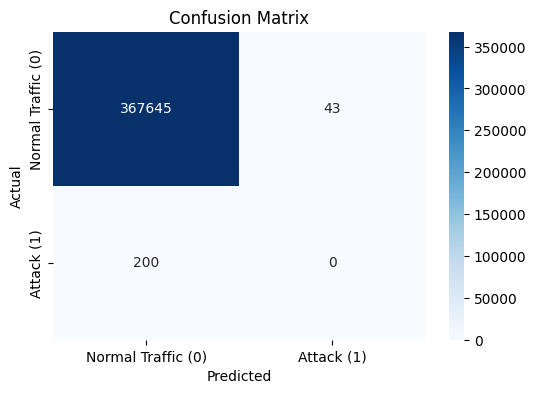

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    367688
        Attack       0.00      0.00      0.00       200

      accuracy                           1.00    367888
     macro avg       0.50      0.50      0.50    367888
  weighted avg       1.00      1.00      1.00    367888



In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))
